<a href="https://colab.research.google.com/github/Heo-JuYeong/Data_Analysis_Team3_Project/blob/main/Landcover_U_Net_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Landcover_Unet_Colab.ipynb 형태 코드 내용 (Python 셀 기준)
# ✅ 1. Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ✅ 2. 필요한 라이브러리 설치
!pip install numpy==1.26.4 imagecodecs tifffile --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2025.6.1
    Uninstalling tifffile-2025.6.1:
      Successfully uninstalled tifffile-2025.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
# ✅ 3. 라이브러리 임포트
import os
import random
import shutil
import imagecodecs
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tifffile import imread

In [ ]:
# ✅ 4. 데이터셋 자동 분할 함수
def split_dataset(image_dir, mask_dir, output_base, split_ratio=(0.7, 0.2, 0.1)):
    images = sorted(glob(os.path.join(image_dir, '*.tif')))
    masks = sorted(glob(os.path.join(mask_dir, '*.tif')))
    assert len(images) == len(masks), "이미지와 마스크 수 불일치"

    data = list(zip(images, masks))
    random.shuffle(data)
    n_total = len(data)
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)

    splits = {
        'train': data[:n_train],
        'val': data[n_train:n_train + n_val],
        'test': data[n_train + n_val:]
    }

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_base, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_base, 'masks', split), exist_ok=True)
        for img_path, mask_path in splits[split]:
            shutil.copy(img_path, os.path.join(output_base, 'images', split, os.path.basename(img_path)))
            shutil.copy(mask_path, os.path.join(output_base, 'masks', split, os.path.basename(mask_path)))

In [ ]:
import torch
import torch.nn as nn

# 클래스 수 정의
NUM_CLASSES = 9

# ✅ U-Net 모델 정의 (순수 정의만, 인스턴스 생성 X)
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        # 인코더
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.pool = nn.MaxPool2d(2)

        # 디코더
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)               # [B, 64, H, W]
        e2 = self.enc2(self.pool(e1))   # [B, 128, H/2, W/2]
        e3 = self.enc3(self.pool(e2))   # [B, 256, H/4, W/4]

        d2 = self.up2(e3)               # [B, 128, H/2, W/2]
        d2 = torch.cat([d2, e2], dim=1) # [B, 256, H/2, W/2]
        d2 = self.dec2(d2)              # [B, 128, H/2, W/2]

        d1 = self.up1(d2)               # [B, 64, H, W]
        d1 = torch.cat([d1, e1], dim=1) # [B, 128, H, W]
        d1 = self.dec1(d1)              # [B, 64, H, W]

        out = self.final(d1)            # [B, n_classes, H, W]
        return out


In [ ]:
import os
import torch
import numpy as np
from glob import glob
from tifffile import imread
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# ✅ 클래스 매핑 정의
LABEL_MAP = {
    10: 0,   # 건물
    20: 1,   # 주차장
    30: 2,   # 도로
    40: 3,   # 가로수
    50: 4,   # 논
    60: 5,   # 밭
    70: 6,   # 산림
    80: 7,   # 나지
    100: 8   # 비대상지
}

NUM_CLASSES = 9
CLASS_NAMES = [
    'Building', 'Parking lot', 'Road', 'Tree line',
    'Rice field', 'Crop field', 'Forest', 'Bare land', 'No-data'
]

# ✅ 마스크 리매핑 함수 (255: 무시 클래스)
def remap_mask(mask_np):
    remapped = np.full_like(mask_np, fill_value=255)
    for src, dst in LABEL_MAP.items():
        remapped[mask_np == src] = dst
    return remapped

# ✅ Dataset 클래스
class LandCoverTifDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.tif')))
        assert len(self.image_paths) == len(self.mask_paths), "이미지와 마스크 수 불일치"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = imread(self.image_paths[idx])
        mask = imread(self.mask_paths[idx])

        # 이미지 전처리
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        elif image.ndim == 3:
            if image.shape[2] in [3, 4]:  # HWC
                image = image[:, :, :3]
            elif image.shape[0] in [3, 4]:  # CHW
                image = np.transpose(image[:3], (1, 2, 0))
            else:
                raise ValueError(f"예상치 못한 이미지 shape: {image.shape}")

        image = image.astype(np.float32) / 255.0
        image = torch.FloatTensor(image).permute(2, 0, 1)

        # 마스크 리매핑 및 변환
        mask = mask.astype(np.int64)
        mask = remap_mask(mask)
        mask = torch.LongTensor(mask)

        return image, mask

# ✅ 손실 함수 정의 (255는 무시)
criterion = nn.CrossEntropyLoss(ignore_index=255)

In [ ]:
# ✅ 7. 학습 루프
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    if len(loader) == 0:
        return 0.0, 0.0

    for img, mask in loader:
        img, mask = img.to(device), mask.to(device)

        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, mask)
        loss.backward()

        # Gradient clipping (선택)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        pred = torch.argmax(out, dim=1)

        valid = mask != 255  # 무시할 픽셀 제외
        correct += (pred[valid] == mask[valid]).sum().item()
        total += valid.sum().item()

    acc = 100. * correct / total if total > 0 else 0.0
    return total_loss / len(loader), acc

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
def main():
    base_dir = '/content/drive/MyDrive/Colab Notebooks/3조 프로젝트 폴더/landcover_dataset'
    image_main = os.path.join(base_dir, 'images/main1')
    mask_main = os.path.join(base_dir, 'masks/main')

    image_dir = os.path.join(base_dir, 'images/train')
    mask_dir = os.path.join(base_dir, 'masks/train')

    batch_size = 4
    lr = 1e-3
    epochs = 50

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataset = LandCoverTifDataset(image_dir, mask_dir)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = UNet(NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device), ignore_index=255)

    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0

        model.train()
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            valid = (masks != 255)
            correct += (preds[valid] == masks[valid]).sum().item()
            total += valid.sum().item()

        avg_loss = running_loss / len(loader)
        acc = (correct / total) * 100 if total > 0 else 0.0

        print(f"[{epoch+1:02d}/{epochs}] Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")

    # ✅ 학습 종료 후 모델 저장
    save_path = os.path.join(base_dir, 'landcover_unet_colab.pth')
    torch.save(model.state_dict(), save_path)
    print(f"✅ 모델 저장 완료: {save_path}")

# 실행
main()

[01/50] Loss: 1.2805 | Acc: 49.67%
[02/50] Loss: 0.9850 | Acc: 61.38%
[03/50] Loss: 0.8686 | Acc: 65.93%
[04/50] Loss: 0.8286 | Acc: 67.44%
[05/50] Loss: 0.7248 | Acc: 72.40%
[06/50] Loss: 0.6974 | Acc: 73.76%
[07/50] Loss: 0.6514 | Acc: 75.57%
[08/50] Loss: 0.6054 | Acc: 77.45%
[09/50] Loss: 0.6164 | Acc: 76.69%
[10/50] Loss: 0.5712 | Acc: 78.50%
[11/50] Loss: 0.5376 | Acc: 79.93%
[12/50] Loss: 0.5241 | Acc: 80.42%
[13/50] Loss: 0.5004 | Acc: 81.38%
[14/50] Loss: 0.4945 | Acc: 81.58%
[15/50] Loss: 0.5428 | Acc: 79.93%
[16/50] Loss: 0.4836 | Acc: 81.85%
[17/50] Loss: 0.4779 | Acc: 82.13%
[18/50] Loss: 0.4668 | Acc: 82.58%
[19/50] Loss: 0.4765 | Acc: 82.24%
[20/50] Loss: 0.4527 | Acc: 82.97%
[21/50] Loss: 0.4397 | Acc: 83.50%
[22/50] Loss: 0.4444 | Acc: 83.25%
[23/50] Loss: 0.4470 | Acc: 83.35%
[24/50] Loss: 0.4341 | Acc: 83.72%
[25/50] Loss: 0.4227 | Acc: 84.14%
[26/50] Loss: 0.4144 | Acc: 84.36%
[27/50] Loss: 0.4227 | Acc: 84.23%
[28/50] Loss: 0.4120 | Acc: 84.55%
[29/50] Loss: 0.4204

In [ ]:
import torch
from torch.utils.data import DataLoader

# ✅ device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ 검증용 DataLoader 구성
val_dataset = LandCoverTifDataset(
    '/content/drive/MyDrive/Colab Notebooks/3조 프로젝트 폴더/landcover_dataset/images/val',
    '/content/drive/MyDrive/Colab Notebooks/3조 프로젝트 폴더/landcover_dataset/masks/val'
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# ✅ 모델 불러오기 및 평가 모드 설정
model = UNet(NUM_CLASSES).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/3조 프로젝트 폴더/landcover_dataset/landcover_unet_colab.pth'))
model.eval()

# ✅ 정확도 계산
val_correct = 0
val_total = 0
with torch.no_grad():
    for val_img, val_mask in val_loader:
        val_img, val_mask = val_img.to(device), val_mask.to(device)
        val_out = model(val_img)
        val_pred = torch.argmax(val_out, dim=1)
        valid = (val_mask != 255)
        val_correct += (val_pred[valid] == val_mask[valid]).sum().item()
        val_total += valid.sum().item()

val_acc = val_correct / val_total * 100 if val_total > 0 else 0.0
print(f"✅ Validation Accuracy: {val_acc:.2f}%")

✅ Validation Accuracy: 86.37%


In [ ]:
# 테스트 데이터셋 불러오기
test_dataset = LandCoverTifDataset(
    '/content/drive/MyDrive/Colab Notebooks/3조 프로젝트 폴더/landcover_dataset/images/test',
    '/content/drive/MyDrive/Colab Notebooks/3조 프로젝트 폴더/landcover_dataset/masks/test'
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 모델 재사용 또는 재로딩
model = UNet(NUM_CLASSES).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/3조 프로젝트 폴더/landcover_dataset/landcover_unet_colab.pth'))
model.eval()

# 테스트 정확도 계산
test_correct, test_total = 0, 0
with torch.no_grad():
    for test_img, test_mask in test_loader:
        test_img, test_mask = test_img.to(device), test_mask.to(device)
        out = model(test_img)
        pred = torch.argmax(out, dim=1)
        valid = (test_mask != 255)
        test_correct += (pred[valid] == test_mask[valid]).sum().item()
        test_total += valid.sum().item()

test_acc = test_correct / test_total * 100 if test_total > 0 else 0.0
print(f"🎯 Test Accuracy: {test_acc:.2f}%")

🎯 Test Accuracy: 86.21%


In [ ]:
import os
import torch
import numpy as np
from tifffile import imread as tif_read
from PIL import Image

def predict_image(model, image_path, device):
    model.eval()
    ext = os.path.splitext(image_path)[-1].lower()

    # 🔍 이미지 로딩 방식 선택
    if ext in ['.tif', '.tiff']:
        image = tif_read(image_path)
    elif ext in ['.jpg', '.jpeg', '.png']:
        image = np.array(Image.open(image_path).convert("RGB"))
    else:
        raise ValueError(f"Unsupported file extension: {ext}")

    # 🔧 채널 정렬
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    elif image.ndim == 3 and image.shape[0] in [3, 4]:
        image = np.transpose(image[:3], (1, 2, 0))

    image = image.astype(np.float32) / 255.0
    tensor = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    return pred

<ipython-input-36-2489323265>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('tab20')
<ipython-input-36-2489323265>:40: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-2489323265>:40: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-2489323265>:40: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-2489323265>:40: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-2489323265>:40: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython

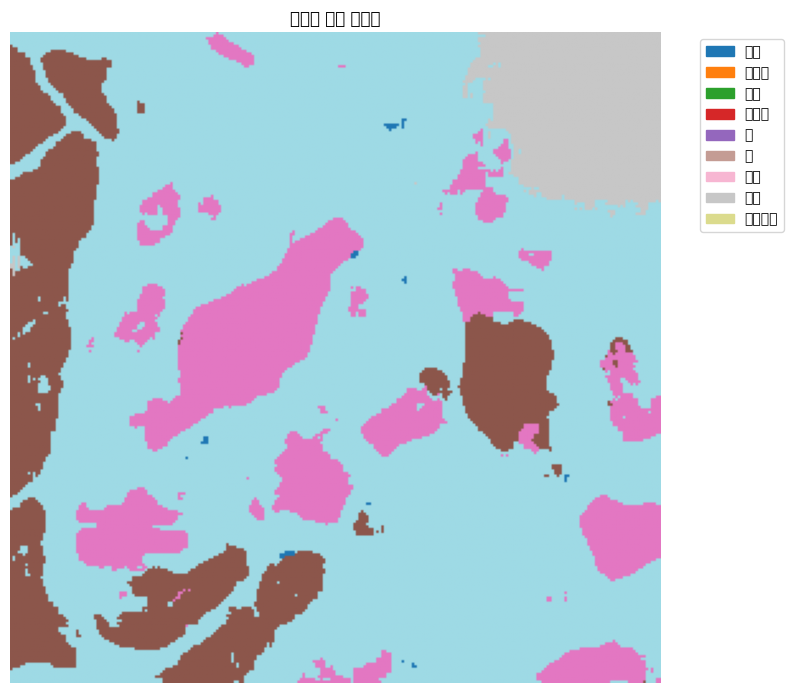

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# 클래스 정의
CLASS_NAMES = ['건물', '주차장', '도로', '가로수', '논', '밭', '산림', '나지', '비대상지']
NUM_CLASSES = len(CLASS_NAMES)
base_cmap = cm.get_cmap('tab20')
COLORS = [base_cmap(i / NUM_CLASSES) for i in range(NUM_CLASSES)]

# 추론 함수
def predict_image(model, image_path, device):
    model.eval()
    image = Image.open(image_path).convert('RGB').resize((256, 256))
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    return pred_mask

# 실행 예시
image_path = '/content/drive/MyDrive/Colab Notebooks/3조 프로젝트 폴더/landcover_dataset/test1/002.jpg'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델은 이미 정의 및 로드되었다고 가정 (예: model.load_state_dict(...) 완료된 상태)
pred_mask = predict_image(model, image_path, device)

# 시각화
plt.figure(figsize=(8, 8))
im = plt.imshow(pred_mask, cmap='tab20', vmin=0, vmax=NUM_CLASSES - 1)
plt.title("예측된 분류 마스크")
plt.axis('off')
handles = [mpatches.Patch(color=COLORS[i], label=CLASS_NAMES[i]) for i in range(NUM_CLASSES)]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from glob import glob
from tifffile import imread
from collections import Counter
import numpy as np

counts = Counter()
for path in glob('/content/drive/MyDrive/.../masks/train/*.tif'):
    m = imread(path)
    m_remap = remap_mask(m)
    classes, class_counts = np.unique(m_remap, return_counts=True)
    counts.update(dict(zip(classes, class_counts)))

print("클래스 분포:", counts)

클래스 분포: Counter()
